<a href="https://colab.research.google.com/github/yamaguchinorimitsu/ajax_app/blob/master/%E3%82%B9%E3%83%83%E3%82%AD%E3%83%AA%E6%A9%9F%E6%A2%B0%E7%AC%AC13%E7%AB%A0%E7%B7%B4%E7%BF%92%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 練習問題
import pandas as pd
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split

# 追加
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import numpy as np #本書ではあまり紹介していないnumpyライブラリ

%matplotlib inline

df = pd.read_csv('/content/Bank.csv')
# まず、ダミー変数化をしたいが、文字列の列が複数あるので抜き出す。
str_col_name=['job','default','marital','education','housing','loan','contact','month']
str_df = df[str_col_name]
#複数列を一気にダミー変数化
str_df2=pd.get_dummies(str_df,drop_first=True)

num_df = df.drop(str_col_name,axis=1)#数値列を抜き出す
df2 = pd.concat([num_df,str_df2,str_df],axis=1)#結合(今後の集計の利便性も考慮してstr_dfも結合しておく)
#訓練&検証データとテストデータに分割
train_val,test = train_test_split(df2,test_size=0.1,random_state=9)
train_val.head()

,id,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,job,default,marital,education,housing,loan,contact,month
13378,13379,46,0.0,10,378.293875,1,0,1,0,0,...,0,0,unemployed,no,married,tertiary,yes,no,cellular,jul
3800,3801,41,-333.0,30,300.845752,3,2,0,1,0,...,0,0,blue-collar,no,divorced,secondary,yes,no,cellular,jan
10398,10399,30,5389.0,6,159.053623,3,0,1,0,0,...,0,0,management,no,single,tertiary,no,no,cellular,aug
23401,23402,39,255.0,5,334.802583,1,0,0,0,0,...,0,0,management,no,single,tertiary,yes,no,sending _document,may
26223,26224,47,33.0,5,NaN,1,0,1,0,0,...,0,0,services,no,single,secondary,yes,no,cellular,may


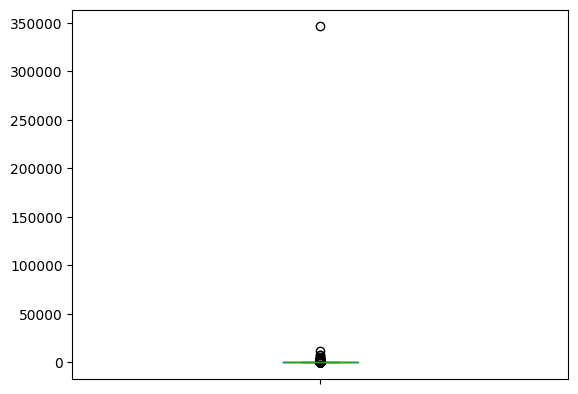

In [2]:
#欠損値の補正
from sklearn.covariance import MinCovDet
num_df=train_val.drop(str_col_name,axis=1)
num_df=num_df.drop('id',axis=1)
num_df2=num_df.dropna()
mcd2 =MinCovDet(random_state=0,support_fraction=0.7)
mcd2.fit(num_df2)
dis =mcd2.mahalanobis(num_df2)
dis=pd.Series(dis)
dis.plot(kind="box")
no=dis[dis>300000].index
#先頭から2561番目が外れ値となる事が分かったので９章の付録で紹介したilocを利用する
no=num_df2.iloc[no[0]:(no[0]+1),:].index
train_val2 = train_val.drop(no)

In [3]:
#欠損行を削除
not_nan_df = train_val2.dropna()#df2は外れ値が無いデータ
temp_t =not_nan_df[['duration']]
temp_x = not_nan_df.drop(str_col_name,axis=1)

#durationとyに関係があるという仮定が成り立つならば、適切な推定をするためには,
temp_x = temp_x.drop(['y','duration','id'],axis=1)
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso,Ridge

a,b,c,d= train_test_split(temp_x,temp_t,random_state=0,test_size=0.2)
maxvalue=0
v=0
#今回はLasso回帰を利用するので、特徴量選択はしない
for i in range(1,42):
    val = i/20
    model_liner = Lasso(random_state=0,alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner.fit(a,c)
    if maxvalue < model_liner.score(b,d):
        v=val
        maxvalue = model_liner.score(b,d)
print(v,maxvalue)
model_liner = Lasso(random_state=0,alpha=v)
#今回は予測させたいだけなので、標準化はしない
model_liner.fit(a,c)
#pd.Series(model_liner)


0.15 0.7304944115519963


Lasso(alpha=0.15, random_state=0)

In [4]:
#実際に使うのは外れ値込みのデータ
train_val3 = train_val.copy()
is_null=train_val3['duration'].isnull()
temp_x = train_val3.drop(str_col_name,axis=1)
temp_x = temp_x.drop(['y','duration','id'],axis=1)
temp_x = temp_x[is_null]
#non_x=train_val2.loc[is_null,['housing_yes','loan_yes','age','marital_single','job_student']]
pred_d = model_liner.predict(temp_x)
train_val3.loc[is_null,'duration']=pred_d

In [5]:
#12章付録で紹介したアンダーサンプリングを行う
def under_sampling(train_val):
    y_0=train_val[train_val['y']==0]
    y_1=train_val[train_val['y']==1]
    num_1 = len(y_1)
    #Y=1と同じ件数だけサンプリング
    y_0_2 =y_0.sample(n=num_1,random_state=0)
    train_val2 = pd.concat([y_1,y_0_2])
    return train_val2

In [6]:
#まず、さくっと学習できるようなlearn関数を定義する。ただし、正解率では無くて適合率をみる
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
def learn(x,t,i):
    x_train,x_val,y_train,y_val = train_test_split(x,t,test_size=0.2,random_state=13)

    datas=[x_train,x_val,y_train,y_val]
    base = DecisionTreeClassifier(max_depth=i,random_state=0,class_weight="balanced")
    #model = AdaBoostClassifier(n_estimators=150,base_estimator=base,random_state=0)
    
    #　追加
    
    base.fit(x_train,y_train)
    train_pred = base.predict(x_train)
    test_pred = base.predict(x_val)
    result = classification_report(y_pred=test_pred,y_true=y_val,output_dict=True)
    return result,base,datas

t =train_val3['y']
x = train_val3.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
res,model,datas = learn(x,t,i=8)
res_df=pd.DataFrame(res)
res_df
#res_df.iloc[0,1]

,0,1,accuracy,macro avg,weighted avg
precision,0.908992,0.587765,0.769199,0.748378,0.810315
recall,0.741058,0.832667,0.769199,0.786862,0.769199
f1-score,0.816479,0.689103,0.769199,0.752791,0.777351
support,3383.000000,1500.000000,0.769199,4883.000000,4883.000000


In [8]:
#適合率が低い。
# 12章で学習したランダムフォレストとアダブーストだとどうなるか？
def learn2(x,t,i,de=5,forest=True):
    x_train,x_val,y_train,y_val = train_test_split(x,t,test_size=0.2,random_state=13)

    datas=[x_train,x_val,y_train,y_val]
    model=None
    if forest:
        model = RandomForestClassifier(n_estimators=i,random_state=0,max_depth=de,class_weight="balanced")
    #datas=[x_train,x_val,y_train,y_val]
    else:
        base = DecisionTreeClassifier(max_depth=de,random_state=0,class_weight="balanced")
        model = AdaBoostClassifier(n_estimators=i,base_estimator=base,random_state=0)
    #model = AdaBoostClassifier(n_estimators=150,base_estimator=base,random_state=0)
    model.fit(x_train,y_train)
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_val)
    result = classification_report(y_pred=test_pred,y_true=y_val,output_dict=True)
    return result,model,datas
t =train_val3['y']
x = train_val3.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)

In [10]:
#ランダムフォレストでの検証
print("=================random_forest=========================")
max_pre=0
for i in [50,100,150,200]:#esti
    for j in range(5,11):#depth
        res,model,datas = learn2(x,t,i=i,de=j,forest=True)
        res2=pd.DataFrame(res)
        pre = res2.iloc[0,1]
        if max_pre < pre:
            max_pre=pre
            print(max_pre,i,j)
        print(i,j,pre,"finish next_i")
#アダブーストでの検証
print("=================adaboost=========================")
max_pre=0
for i in [50,100,150,200]:#esti
    for j in range(5,11):#depth
        res,model,datas = learn2(x,t,i=i,de=j,forest=False)
        res2=pd.DataFrame(res)
        pre = res2.iloc[0,1]
        if max_pre < pre:
            max_pre=pre
            print(max_pre,i,j)
        print(i,j,pre,"finish next_i")


=================random_forest=========================
0.559322033898305 50 5
50 5 0.559322033898305 finish next_i
0.5614552605703048 50 6
50 6 0.5614552605703048 finish next_i
0.5669099756690997 50

KeyboardInterrupt: ignored

In [12]:
#非常に時間がかかるので途中で終了。
#random_forestよりadaboostの方がvalデータの精度が良く、その中でもestimator=100,max_depth=8が最も高い

#estimatorの値を100と固定して、max_depthについての考察を深める。k-分割交差検証
#で最適なmax_depthを考察するｂ
def learn_k_valid(x,t,i,dep):
    base = DecisionTreeClassifier(max_depth=dep,random_state=0,class_weight="balanced")
    model = AdaBoostClassifier(n_estimators=150,base_estimator=base,random_state=0)
    kv = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)
    result = cross_validate(model,x,t,cv=kv,scoring='precision',return_train_score=True)
    
    #base.fit(x_train,y_train)
    #train_pred = base.predict(x_train)
    #test_pred = base.predict(x_val)
    #result = classification_report(y_pred=test_pred,y_true=y_val,output_dict=True)
    return result


In [13]:
t =train_val3['y']
x = train_val3.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
for j in range(2,10):
    res = learn_k_valid(x,t,i=100,dep=j)
    res2=res["train_score"]
    print(j,sum(res2)/len(res2),end="  ")#平均値    
    res3=res["test_score"]
    
    print(j,sum(res3)/len(res3))#平均値
    print(" j end next")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


2 0.693870965005931  2 0.6559046281758386
 j end next


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


3 0.7362327964398089  3 0.6422741329937129
 j end next


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


4 0.8255270119809314  4 0.6295671648612825
 j end next


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


5 0.9528726670921518  5 0.6319990236252875
 j end next


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


6 1.0  6 0.6313672965199527
 j end next


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


7 1.0  7 0.6523153407424451
 j end next


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


8 1.0  8 0.6787935210450776
 j end next


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


9 1.0  9 0.6912890747412347
 j end next
